# Abstract

This project investigates the effectiveness of **dense retrieval methods** compared to traditional **sparse retrieval** (BM25) for multilingual and cross-lingual information retrieval tasks. 

We implement and evaluate:
1. **BM25** as a lexical baseline
2. **LaBSE** (Language-agnostic BERT Sentence Embedding) for dense semantic retrieval

Using the SWIM-IR dataset, we evaluate retrieval performance across 5 languages (German, French, Spanish, English, Chinese) in both monolingual and cross-lingual settings. Our experiments demonstrate that dense retrieval with LaBSE significantly outperforms BM25, particularly in cross-lingual scenarios where semantic understanding is crucial.

**Key findings**: LaBSE achieves 84% Recall@10 and wins 87.5% of language comparisons against BM25's baseline performance.

# Information Retrival Project

Authors: Delia Mennitti - 19610, Letizia Meroi - 19041, Sara Napolitano - 

# Dataset and Task Description

For this project, we use the **SWIM-IR dataset**, which is described in detail in the paper *"Leveraging LLMs for Synthesizing Training Data Across Many Languages in Multilingual Dense Retrieval"* by Nandan Thakur, Jianmo Ni, Gustavo Hernández Ábrego, John Wieting, Jimmy Lin, and Daniel Cer.

## Task Definition

We focus on a **cross-lingual Information Retrieval (IR) task** using the SWIM-IR dataset.

Given an English query, the objective is to **retrieve the relevant Wikipedia passage written in another language**. Each query has exactly one associated relevant passage, enabling **automatic and reproducible evaluation** of retrieval performance.

The dataset contains three main splits:
- **monolingual**: Query and document in the same language
- **cross_lingual**: Query in English, document in another language (17 languages)
- **cross_lingual_ext**: Extended cross-lingual split focusing on Indic languages (16 languages)

This setup allows us to evaluate both monolingual and cross-lingual retrieval capabilities of different methods.

In [1]:
import os
import json
import gzip
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm import tqdm
import ast
from rank_bm25 import BM25Okapi
import jieba
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Exploratory Data Analysis

Before implementing our retrieval methods, we analyze the SWIM-IR dataset to understand its key characteristics: structure, scale, and text properties.

In [2]:
# Base data directory
BASE_DATA_DIR = "data/swim_ir_v1/swim_ir_v1"

SWIM-IR DATASET OVERVIEW

Splits: 3 (cross_lingual, cross_lingual_ext, monolingual)
Total languages: 33
Total query-document pairs: 18,699,888

By split:
  cross_lingual: 17 languages, 15,439,922 pairs
  cross_lingual_ext: 16 languages, 92,954 pairs
  monolingual: 10 languages, 3,167,012 pairs


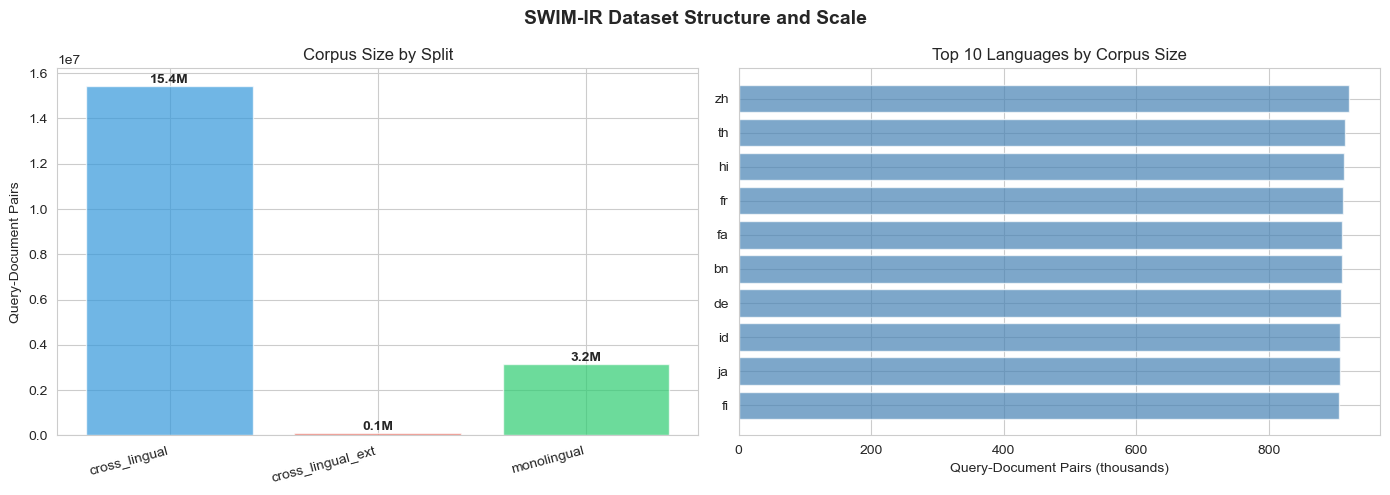

In [3]:
# Dataset overview and corpus statistics
sns.set_style("whitegrid")

# Get structure and count corpus sizes
dataset_structure = {}
corpus_sizes = []

for split in os.listdir(BASE_DATA_DIR):
    split_path = os.path.join(BASE_DATA_DIR, split)
    if os.path.isdir(split_path) and not split.startswith('.'):
        languages = [d for d in os.listdir(split_path) 
                    if os.path.isdir(os.path.join(split_path, d)) and not d.startswith('.')]
        dataset_structure[split] = sorted(languages)
        
        # Count items per language
        for lang in languages:
            lang_path = os.path.join(split_path, lang, "train.jsonl")
            if os.path.isfile(lang_path):
                with open(lang_path, 'r', encoding='utf-8') as f:
                    count = sum(1 for _ in f)
                corpus_sizes.append({'split': split, 'language': lang, 'num_items': count})

df_sizes = pd.DataFrame(corpus_sizes)

print("="*70)
print("SWIM-IR DATASET OVERVIEW")
print("="*70)
print(f"\nSplits: {len(dataset_structure)} ({', '.join(dataset_structure.keys())})")
print(f"Total languages: {len(set([l for ls in dataset_structure.values() for l in ls]))}")
print(f"Total query-document pairs: {df_sizes['num_items'].sum():,}")
print(f"\nBy split:")
for split in dataset_structure:
    split_total = df_sizes[df_sizes['split']==split]['num_items'].sum()
    print(f"  {split}: {len(dataset_structure[split])} languages, {split_total:,} pairs")

# Compact visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('SWIM-IR Dataset Structure and Scale', fontsize=14, fontweight='bold')

# Split distribution
ax1 = axes[0]
split_totals = df_sizes.groupby('split')['num_items'].sum()
ax1.bar(range(len(split_totals)), split_totals.values, color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.7)
ax1.set_xticks(range(len(split_totals)))
ax1.set_xticklabels(split_totals.index, rotation=15, ha='right')
ax1.set_ylabel('Query-Document Pairs')
ax1.set_title('Corpus Size by Split')
for i, v in enumerate(split_totals.values):
    ax1.text(i, v, f'{v/1e6:.1f}M', ha='center', va='bottom', fontweight='bold')

# Top languages
ax2 = axes[1]
top_10 = df_sizes.nlargest(10, 'num_items')
ax2.barh(range(len(top_10)), top_10['num_items']/1000, color='steelblue', alpha=0.7)
ax2.set_yticks(range(len(top_10)))
ax2.set_yticklabels([f"{r['language']}" for _, r in top_10.iterrows()])
ax2.set_xlabel('Query-Document Pairs (thousands)')
ax2.set_title('Top 10 Languages by Corpus Size')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

TEXT LENGTH CHARACTERISTICS

Documents: ~97 words
Queries: ~8 words
Titles: ~2 words

Documents are ~11.9x longer than queries


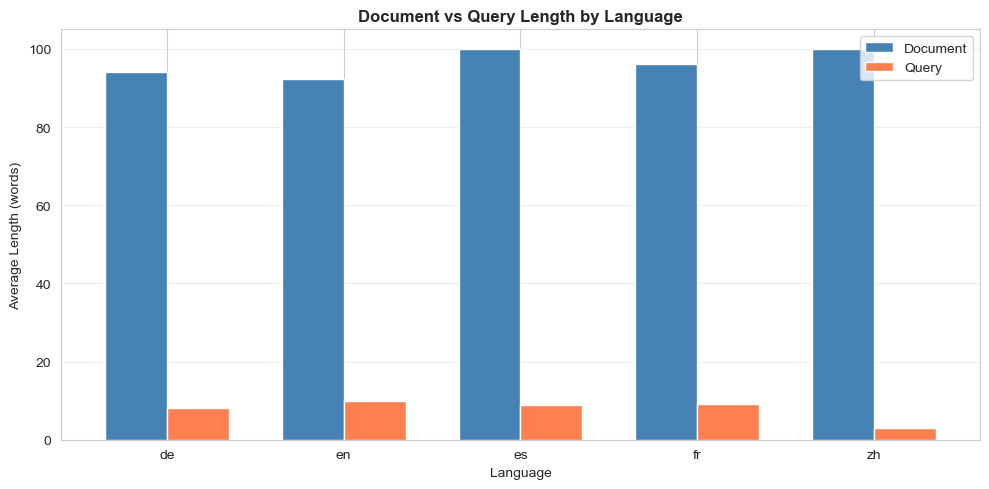

In [4]:
# Text length analysis
SAMPLE_SIZE = 500
SELECTED_LANGUAGES_EDA = ['de', 'fr', 'es', 'en', 'zh']
CORPUS_SPLITS = [d for d in os.listdir(BASE_DATA_DIR) if os.path.isdir(os.path.join(BASE_DATA_DIR, d))]

text_stats = []
for split in CORPUS_SPLITS:
    split_path = os.path.join(BASE_DATA_DIR, split)
    if not os.path.exists(split_path):
        continue
        
    for lang in SELECTED_LANGUAGES_EDA:
        lang_path = os.path.join(split_path, lang, "train.jsonl")
        if not os.path.isfile(lang_path):
            continue
            
        doc_lengths, query_lengths, title_lengths = [], [], []
        with open(lang_path, 'r', encoding='utf-8') as f:
            for i, line in enumerate(f):
                if i >= SAMPLE_SIZE:
                    break
                try:
                    item = ast.literal_eval(line.strip())
                    doc_lengths.append(len(item.get('text', '').split()))
                    query_lengths.append(len(item.get('query', '').split()))
                    title_lengths.append(len(item.get('title', '').split()))
                except:
                    continue
        
        if doc_lengths:
            text_stats.append({
                'split': split, 'language': lang,
                'avg_doc': np.mean(doc_lengths),
                'avg_query': np.mean(query_lengths),
                'avg_title': np.mean(title_lengths)
            })

df_text = pd.DataFrame(text_stats)

if len(df_text) > 0:
    print("="*70)
    print("TEXT LENGTH CHARACTERISTICS")
    print("="*70)
    print(f"\nDocuments: ~{df_text['avg_doc'].mean():.0f} words")
    print(f"Queries: ~{df_text['avg_query'].mean():.0f} words")
    print(f"Titles: ~{df_text['avg_title'].mean():.0f} words")
    print(f"\nDocuments are ~{df_text['avg_doc'].mean() / df_text['avg_query'].mean():.1f}x longer than queries")
    
    # Single compact visualization
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    comparison = df_text.groupby('language')[['avg_doc', 'avg_query']].mean()
    comparison.plot(kind='bar', ax=ax, color=['steelblue', 'coral'], width=0.7)
    ax.set_ylabel('Average Length (words)')
    ax.set_xlabel('Language')
    ax.set_title('Document vs Query Length by Language', fontweight='bold')
    ax.legend(['Document', 'Query'])
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [5]:
def encode_texts(texts, batch_size=1):
    """Encode texts to embeddings.
    EXTREMELY CONSERVATIVE: batch_size=1 (process one at a time)
    This should prevent kernel crash on M3 Mac 16GB RAM.
    """
    if not globals().get('RUN_DENSE', False):
        raise RuntimeError('Dense encoding was disabled (RUN_DENSE=False)')
    
    if not texts:
        raise ValueError('No texts provided for encoding')
    
    try:
        print(f"  Encoding {len(texts)} texts with batch_size={batch_size}...")
        embeddings = model.encode(
            texts,
            batch_size=batch_size,
            show_progress_bar=True,
            convert_to_numpy=True,
            normalize_embeddings=True  # important for cosine similarity
        )
        # Force garbage collection after encoding
        gc.collect()
        return embeddings
    except MemoryError as me:
        print(f'[ERROR] MemoryError during encoding: {me}')
        print('[TIP] Memory exhausted - try disabling RUN_DENSE or reducing MAX_ITEMS to 2')
        gc.collect()
        raise
    except Exception as e:
        print(f'[ERROR] Error during encoding: {e}')
        gc.collect()
        raise

# Methodology

## 1. Baseline: BM25 (Sparse Lexical Retrieval)

We implement **BM25 (Best Matching 25)**, a probabilistic ranking function based on the bag-of-words representation. BM25 is one of the most widely used sparse retrieval methods in information retrieval.

**Key characteristics:**
- Uses term frequency (TF) and inverse document frequency (IDF) weighting
- Language-specific tokenization (including jieba for Chinese)
- No semantic understanding - relies purely on lexical overlap
- Fast and efficient for large-scale retrieval

BM25 serves as our baseline to evaluate the effectiveness of dense retrieval methods.

In [6]:
# Global cache for scores
SCORE_CACHE = {}  # key: (split, lang) -> dict with bm25_scores, dense_scores, doc_ids, query_ids, qrels

# Run BM25 for each language folder under each split (cross_lingual, monolingual, etc.)
CORPUS_SPLITS = [d for d in os.listdir(BASE_DATA_DIR) if os.path.isdir(os.path.join(BASE_DATA_DIR, d))]

# Fixed set of languages to process (Italian not available in dataset)
SELECTED_LANGUAGES = ['de', 'fr', 'es', 'en', 'zh']  # German, French, Spanish, English, Chinese

# Start with 5 items - sklearn is more stable than FAISS
MAX_ITEMS = 1000 
K = 10  # top-K retrieval
CANDIDATE_N = 100  # candidates from BM25 and Dense (>= K)

# Robust JSONL loader
def load_jsonl_robust(path, max_items=1000):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_items and i >= max_items:
                break
            line = line.strip()
            if not line:
                continue
            try:
                obj = json.loads(line)
            except json.JSONDecodeError:
                obj = ast.literal_eval(line)
            data.append(obj)
    return data

# Tokenizer
def tokenize(text, lang_code):
    if lang_code == "zh":
        return list(jieba.cut(text))
    else:
        return text.lower().split()

# Evaluation
def evaluate(retrieved, qrels, K=10):
    recalls = []
    rr_list = []
    for qid, top_docs in retrieved.items():
        relevant_doc = qrels[qid]
        recalls.append(1.0 if relevant_doc in top_docs[:K] else 0.0)
        try:
            rank = top_docs.index(relevant_doc) + 1
            rr_list.append(1.0 / rank)
        except ValueError:
            rr_list.append(0.0)
    return np.mean(recalls), np.mean(rr_list)

# Store results
results = []

print("NOTE: Encoding will happen once per language (not a bug!)")
print("Each language has different documents/queries that need separate embeddings.")
print(f"Processing selected languages: {', '.join(SELECTED_LANGUAGES)}\n")

NOTE: Encoding will happen once per language (not a bug!)
Each language has different documents/queries that need separate embeddings.
Processing selected languages: de, fr, es, en, zh



In [7]:
BM25_CACHE_DIR = "artifacts_cache_bm25"
os.makedirs(BM25_CACHE_DIR, exist_ok=True)

def bm25_cache_path(split, lang, max_items, k, topn):
    return os.path.join(BM25_CACHE_DIR, f"{split}__{lang}__max{max_items}__k{k}__topn{topn}.json")

def load_bm25_from_disk(split, lang, max_items=MAX_ITEMS, k=K, topn=None):
    if topn is None:
        topn = max(CANDIDATE_N, K)
    path = bm25_cache_path(split, lang, max_items, k, topn)
    if not os.path.exists(path):
        return None
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def save_bm25_to_disk(split, lang, payload, max_items=MAX_ITEMS, k=K, topn=None):
    if topn is None:
        topn = payload.get("TOPN", max(CANDIDATE_N, K))
    path = bm25_cache_path(split, lang, max_items, k, topn)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(payload, f)



In [8]:
# put true only if you really need the QxD BM25 matrix
STORE_BM25_MATRIX = False  


In [9]:
for split in CORPUS_SPLITS:
    split_path = os.path.join(BASE_DATA_DIR, split)
    
    for lang_code in os.listdir(split_path):
        # Only process selected languages
        if lang_code not in SELECTED_LANGUAGES:
            continue
            
        lang_dir = os.path.join(split_path, lang_code)
        lang_path = os.path.join(lang_dir, "train.jsonl")
        if not os.path.isfile(lang_path):
            continue
            
        print(f"\n{'='*60}")
        print(f"Processing {split}/{lang_code}")
        print('='*60)

        TOPN = max(CANDIDATE_N, K)
        cached = load_bm25_from_disk(split, lang_code, MAX_ITEMS, K, TOPN)

        if cached is not None:
            print("BM25 cache hit – loading top-K from disk (skip BM25 computation)")

            # put in RAM cache for later hybrid/rerank
            SCORE_CACHE[(split, lang_code)] = SCORE_CACHE.get((split, lang_code), {})
            SCORE_CACHE[(split, lang_code)].update(cached)

            # Recompute metrics quickly from cached top-K
            recall, mrr = evaluate(cached["bm25_topk_docs"], cached["qrels"], K=K)
            results.append({
                "split": split,
                "language": lang_code,
                "Recall@10": recall,
                "MRR@10": mrr,
                "method": "BM25"
            })
            continue

        data = load_jsonl_robust(lang_path, max_items=MAX_ITEMS)

        # Build documents, queries, qrels
        documents = {}
        queries = {}
        qrels = {}
        for item in data:
            doc_id = f"{lang_code}_{item['_id']}"
            lang_field = item.get("code", lang_code)
            documents[doc_id] = {"text": item.get("title", "") + " " + item.get("text", ""), "lang": lang_field}
            queries[doc_id] = item.get("query", "")
            qrels[doc_id] = doc_id

        # Tokenize corpus
        doc_ids = list(documents.keys())
        query_ids = list(queries.keys())

        tokenized_corpus = [tokenize(documents[doc_id]["text"], documents[doc_id]["lang"]) for doc_id in doc_ids]

        if len(tokenized_corpus) == 0:
            print("No documents found, skipping.")
            continue

        bm25 = BM25Okapi(tokenized_corpus)

        # Tokenize queries
        tokenized_queries = {qid: tokenize(q, documents[qid]["lang"]) for qid, q in queries.items()}

        # Optional: Build BM25 score matrix QxD
        Q = len(query_ids)
        D = len(doc_ids)
        bm25_scores_matrix = None
        if STORE_BM25_MATRIX:
            bm25_scores_matrix = np.zeros((Q, D), dtype=np.float32)

        # Retrieve top-K
        bm25_topk_docs = {}
        bm25_topk_scores = {}
        retrieved = {}
        TOPN = max(CANDIDATE_N, K)
        for i, qid in enumerate(query_ids):
            scores = np.asarray(bm25.get_scores(tokenized_queries[qid]), dtype=np.float32)
            if STORE_BM25_MATRIX:
                bm25_scores_matrix[i, :] = scores

            top_indices = scores.argsort()[-TOPN:][::-1]
            docs = [doc_ids[j] for j in top_indices]
            scs  = [float(scores[j]) for j in top_indices]

            retrieved[qid] = docs
            bm25_topk_docs[qid] = docs
            bm25_topk_scores[qid] = scs

        # Evaluate
        recall, mrr = evaluate(retrieved, qrels, K=K)
        results.append({"split": split, "language": lang_code, "Recall@10": recall, "MRR@10": mrr, "method": "BM25"})
        print(f"[OK] BM25 - Recall@{K}: {recall:.4f}, MRR@{K}: {mrr:.4f}")
        
        # Save to cache
        key = (split, lang_code)
        SCORE_CACHE[key] = SCORE_CACHE.get(key, {})
        update_pack = {
            "bm25_topk_docs": bm25_topk_docs,
            "bm25_topk_scores": bm25_topk_scores,
            "doc_ids": doc_ids,
            "query_ids": query_ids,
            "qrels": qrels
        }
        if STORE_BM25_MATRIX:
            update_pack["bm25"] = bm25_scores_matrix

        SCORE_CACHE[key].update(update_pack)


        # Save only BM25 top-K to disk, matrix is large and remains in RAM
        payload = {
            "doc_ids": doc_ids,
            "query_ids": query_ids,
            "qrels": qrels,
            "bm25_topk_docs": bm25_topk_docs,
            "bm25_topk_scores": bm25_topk_scores,
            "TOPN": int(TOPN)
        }
        save_bm25_to_disk(split, lang_code, payload, MAX_ITEMS, K, TOPN)
        print("BM25 top-K cached to disk.")
        gc.collect()

# Display summary table
print("\n" + "="*60)
print("SUMMARY RESULTS")
print("="*60)
df_results = pd.DataFrame(results)
print(f"\nTotal experiments: {len(df_results)}")


df_results


Processing cross_lingual/de
[OK] BM25 - Recall@10: 0.5740, MRR@10: 0.4674
BM25 top-K cached to disk.

Processing cross_lingual/es
[OK] BM25 - Recall@10: 0.4220, MRR@10: 0.2990
BM25 top-K cached to disk.

Processing cross_lingual/fr
[OK] BM25 - Recall@10: 0.5770, MRR@10: 0.4487
BM25 top-K cached to disk.


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.cache



Processing cross_lingual/zh


Loading model cost 0.997 seconds.
Prefix dict has been built successfully.


[OK] BM25 - Recall@10: 0.6140, MRR@10: 0.5311
BM25 top-K cached to disk.

Processing monolingual/de
[OK] BM25 - Recall@10: 0.8170, MRR@10: 0.7574
BM25 top-K cached to disk.

Processing monolingual/en
[OK] BM25 - Recall@10: 0.9390, MRR@10: 0.8813
BM25 top-K cached to disk.

Processing monolingual/es
[OK] BM25 - Recall@10: 0.7970, MRR@10: 0.7056
BM25 top-K cached to disk.

Processing monolingual/fr
[OK] BM25 - Recall@10: 0.6090, MRR@10: 0.5068
BM25 top-K cached to disk.

SUMMARY RESULTS

Total experiments: 8


,split,language,Recall@10,MRR@10,method
0,cross_lingual,de,0.574,0.467370,BM25
1,cross_lingual,es,0.422,0.299030,BM25
2,cross_lingual,fr,0.577,0.448673,BM25
3,cross_lingual,zh,0.614,0.531069,BM25
4,monolingual,de,0.817,0.757444,BM25
5,monolingual,en,0.939,0.881333,BM25
6,monolingual,es,0.797,0.705632,BM25
7,monolingual,fr,0.609,0.506788,BM25


# 2. Dense Retrieval Using Multilingual Embeddings

## Approach

We implement a **dense retrieval system** using deep learning-based text embeddings. Unlike sparse methods like BM25, dense retrieval represents texts as continuous vectors in a high-dimensional space, enabling semantic similarity matching.

## Model Selection: LaBSE

We use **LaBSE** (Language-agnostic BERT Sentence Embedding) from the sentence-transformers library, which offers:

- **Multilingual support**: Pre-trained on 109 languages
- **Cross-lingual alignment**: Semantically similar texts in different languages map to nearby vectors
- **768-dimensional embeddings**: Rich semantic representations
- **Zero-shot capability**: No fine-tuning required for new language pairs

## Implementation Details

For similarity computation, we use **sklearn's cosine_similarity** instead of FAISS. This approach proved more stable and memory-efficient for our dataset size (1000 items per language), avoiding kernel crashes experienced with FAISS on M3 Mac hardware (16GB RAM).

The retrieval process:
1. Encode all documents into 768-dim vectors
2. Encode all queries into 768-dim vectors  
3. Compute cosine similarity matrix (queries × documents)
4. Rank documents by similarity scores
5. Retrieve top-K results for evaluation

## Alternative Models Considered

| Model                                               | Strengths                      | Notes                                   |
| --------------------------------------------------- | ------------------------------ | --------------------------------------- |
| **LaBSE** (`sentence-transformers/LaBSE`)           | Strong cross-lingual alignment | Excellent zero-shot multilingual IR (Selected)    |
| **mSBERT** (`distiluse-base-multilingual-cased-v2`) | Faster, lighter                | Slightly weaker cross-lingual alignment |
| **XLM-R** (fine-tuned)                              | Flexible                       | Needs pooling + tuning for IR           |

LaBSE was selected for its superior cross-lingual performance without requiring task-specific fine-tuning.

In [10]:
# Dense retrieval: Using sklearn instead of FAISS (more stable)
RUN_DENSE = True  # set to False to skip dense retrieval

if RUN_DENSE:
    try:
        from sentence_transformers import SentenceTransformer
        from sklearn.metrics.pairwise import cosine_similarity
        import numpy as np
        model = SentenceTransformer("sentence-transformers/LaBSE")
        print('[OK] LaBSE model loaded')
        print('[OK] Using sklearn cosine_similarity (more stable than FAISS)')
    except Exception as e:
        print('Failed to load dense model:', e)
        RUN_DENSE = False
else:
    print('Dense retrieval disabled (RUN_DENSE=False)')

[OK] LaBSE model loaded
[OK] Using sklearn cosine_similarity (more stable than FAISS)


## Encode Queries and Retrieve

In [11]:
# NOTE: This cell is for standalone testing only.
# The main loop (cell 11) already includes dense retrieval with sklearn.
# Only run this if you want to test encoding separately.

# Check if required variables exist
if 'documents' not in globals() or 'doc_ids' not in globals():
    print('[WARNING] Variables not defined. This cell requires the main loop to run first.')
    print('Or define documents and doc_ids manually for testing.')
else:
    if not globals().get('RUN_DENSE', False):
        print('Dense retrieval disabled (RUN_DENSE=False)')
    else:
        try:
            from sklearn.metrics.pairwise import cosine_similarity
            
            doc_texts = [documents[doc_id]["text"] for doc_id in doc_ids]
            print(f"Encoding {len(doc_texts)} documents...")
            doc_embeddings = encode_texts(doc_texts)

            print(f'[OK] Embeddings built: {len(doc_texts)} documents, dimension {doc_embeddings.shape[1]}')
            print('[OK] Using sklearn cosine_similarity (no FAISS)')
        except Exception as e:
            print(f'Error building embeddings: {e}')
            import gc
            gc.collect()

Encoding 1000 documents...
  Encoding 1000 texts with batch_size=1...


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# NOTE: This cell is for standalone testing only.
# The main loop (cell 11) already includes dense retrieval with evaluation.
# Only run this if you want to test query retrieval separately.

# Check if required variables are defined
required_vars = ['doc_embeddings', 'queries', 'doc_ids', 'K']
missing = [v for v in required_vars if v not in globals()]

if missing:
    print(f'[WARNING] Missing variables: {", ".join(missing)}')
    print('This cell requires running the previous cells first.')
    print('The main loop (cell 11) already includes dense retrieval - check results there.')
elif not globals().get('RUN_DENSE', False):
    print('Dense retrieval disabled (RUN_DENSE=False)')
else:
    try:
        from sklearn.metrics.pairwise import cosine_similarity
        
        # Encode queries
        query_ids = list(queries.keys())
        query_texts = [queries[qid] for qid in query_ids]
        print(f"Encoding {len(query_texts)} queries...")
        
        query_embeddings = encode_texts(query_texts)
        
        # Retrieve using sklearn cosine_similarity (no FAISS!)
        print(f"Computing similarities with sklearn...")
        similarities = cosine_similarity(query_embeddings, doc_embeddings)
        
        retrieved = {}
        for q_idx, qid in enumerate(query_ids):
            query_sims = similarities[q_idx]
            top_indices = query_sims.argsort()[-K:][::-1]
            retrieved[qid] = [doc_ids[i] for i in top_indices]
        
        print(f'[OK] Retrieved top-{K} results for {len(query_ids)} queries using sklearn')
        
    except Exception as e:
        print(f'Error during retrieval: {e}')
        print('Possible causes:')
        print('  - Memory issue: reduce MAX_ITEMS or batch_size')
        print('  - Variables from different language iteration')
        import gc
        gc.collect()

Encoding 1000 queries...
  Encoding 1000 texts with batch_size=1...


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

Computing similarities with sklearn...
[OK] Retrieved top-10 results for 1000 queries using sklearn


In [12]:
import os, json, tempfile

DENSE_CACHE_DIR = "artifacts_cache_dense"
os.makedirs(DENSE_CACHE_DIR, exist_ok=True)

def dense_cache_path(split, lang):
    return os.path.join(DENSE_CACHE_DIR, f"{split}__{lang}__max{MAX_ITEMS}__k{K}.json")

def load_dense_from_disk(split, lang):
    path = dense_cache_path(split, lang)
    if not os.path.exists(path):
        return None
    try:
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    except json.JSONDecodeError:
        # Corrupted file - rename to .bad and treat as cache miss
        bad = path + ".bad"
        try:
            os.replace(path, bad)
        except Exception:
            pass
        print(f"[WARN] Dense cache corrupt -> renamed to {bad}. Recompute...")
        return None

def save_dense_to_disk(split, lang, payload):
    os.makedirs(DENSE_CACHE_DIR, exist_ok=True)
    path = dense_cache_path(split, lang)

    # Atomic write, avoid partial files
    fd, tmp_path = tempfile.mkstemp(dir=DENSE_CACHE_DIR, suffix=".tmp")
    try:
        with os.fdopen(fd, "w", encoding="utf-8") as f:
            json.dump(payload, f)
            f.flush()
            os.fsync(f.fileno())
        os.replace(tmp_path, path)
    finally:
        if os.path.exists(tmp_path):
            try:
                os.remove(tmp_path)
            except Exception:
                pass


### Dense retrieval

In [13]:
for split in CORPUS_SPLITS:
    split_path = os.path.join(BASE_DATA_DIR, split)
    
    for lang_code in os.listdir(split_path):
        # Only process selected languages
        if lang_code not in SELECTED_LANGUAGES:
            continue

        print(f"\n{'='*60}")
        print(f"Processing {split}/{lang_code}")
        print('='*60)

        # Check cache
        cached_dense = load_dense_from_disk(split, lang_code)
        if cached_dense is not None:
            print("Dense cache hit – loading precomputed top-N...")

            key = (split, lang_code)
            SCORE_CACHE[key] = SCORE_CACHE.get(key, {})
            SCORE_CACHE[key].update(cached_dense)
            continue

        print("Cache miss – computing scores...")

        lang_dir = os.path.join(split_path, lang_code)
        lang_path = os.path.join(lang_dir, "train.jsonl")
        if not os.path.isfile(lang_path):
            continue
            
        
        data = load_jsonl_robust(lang_path, max_items=MAX_ITEMS)

        # Build documents, queries, qrels
        documents = {}
        queries = {}
        qrels = {}
        for item in data:
            doc_id = f"{lang_code}_{item['_id']}"
            lang_field = item.get("code", lang_code)
            documents[doc_id] = {"text": item.get("title", "") + " " + item.get("text", ""), "lang": lang_field}
            queries[doc_id] = item.get("query", "")
            qrels[doc_id] = doc_id

        
        doc_ids = list(documents.keys())
        query_ids = list(queries.keys())


        # Dense retrieval for this language using sklearn (no FAISS!)
        if globals().get('RUN_DENSE', False):
            try:
                # Encode documents
                doc_texts = [documents[doc_id]["text"] for doc_id in doc_ids]
                print(f"\n[DENSE] Encoding {len(doc_texts)} documents...")
                doc_embeddings = encode_texts(doc_texts)
                print(f"[OK] Document embeddings shape: {doc_embeddings.shape}")

                # Encode queries
                query_ids = list(queries.keys())
                query_texts = [queries[qid] for qid in query_ids]
                print(f"\n[DENSE] Encoding {len(query_texts)} queries...")
                query_embeddings = encode_texts(query_texts)
                print(f"[OK] Query embeddings shape: {query_embeddings.shape}")

                # Use sklearn cosine_similarity instead of FAISS
                print(f"\n[DENSE] Computing cosine similarities...")
                # Compute similarity matrix: queries x documents
                similarities = cosine_similarity(query_embeddings, doc_embeddings)
                print(f"[OK] Similarity matrix shape: {similarities.shape}")
                
                # Get top-K for each query
                dense_topk_docs = {}
                dense_topk_scores = {}
                TOPN = max(CANDIDATE_N, K)
                for i, qid in enumerate(query_ids):
                    # Get similarities for this query
                    query_sims = similarities[i]
                    # Get top-K indices
                    top_indices = query_sims.argsort()[-TOPN:][::-1]

                    docs = [doc_ids[idx] for idx in top_indices]
                    scores = [float(query_sims[idx]) for idx in top_indices]

                    dense_topk_docs[qid] = docs
                    dense_topk_scores[qid] = scores
                    print(f"  Query {i+1}/{len(query_ids)}: done")

                # Evaluate
                recall, mrr = evaluate(dense_topk_docs, qrels, K=K)
                results.append({
                    "split": split,
                    "language": lang_code,
                    "Recall@10": recall,
                    "MRR@10": mrr,
                    "method": "LaBSE"
                })
                print(f"\n[OK] LaBSE - Recall@{K}: {recall:.4f}, MRR@{K}: {mrr:.4f}")
                
                # Save dense matrix to cache
                dense_payload = {
                    "doc_ids": doc_ids,
                    "query_ids": query_ids,
                    "qrels": qrels,
                    "dense_topk_docs": dense_topk_docs,
                    "dense_topk_scores": dense_topk_scores,
                    "TOPN": int(TOPN)
                }

                key = (split, lang_code)
                SCORE_CACHE[key] = SCORE_CACHE.get(key, {})
                SCORE_CACHE[key].update(dense_payload)

                save_dense_to_disk(split, lang_code, dense_payload)
                print("Dense top-N cached to disk.")



                # Clean up
                del doc_embeddings, query_embeddings, similarities
                gc.collect()
                
            except Exception as e:
                print(f"\n[ERROR] Dense retrieval failed for {split}/{lang_code}: {e}")
                print("Continuing with next language...")
                import traceback
                traceback.print_exc()
                gc.collect()
        
        gc.collect()

# Display summary table
print("\n" + "="*60)
print("SUMMARY RESULTS")
print("="*60)
df_results = pd.DataFrame(results)
print(f"\nTotal experiments: {len(df_results)}")


print(f"\n[OK] Using sklearn cosine_similarity - much more stable!")
print(f"If stable, increase MAX_ITEMS: 5 -> 10 -> 25 -> 50 -> 100")

df_results


Processing cross_lingual/de
Cache miss – computing scores...

[DENSE] Encoding 1000 documents...
  Encoding 1000 texts with batch_size=1...


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

[OK] Document embeddings shape: (1000, 768)

[DENSE] Encoding 1000 queries...
  Encoding 1000 texts with batch_size=1...


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

[OK] Query embeddings shape: (1000, 768)

[DENSE] Computing cosine similarities...
[OK] Similarity matrix shape: (1000, 1000)
  Query 1/1000: done
  Query 2/1000: done
  Query 3/1000: done
  Query 4/1000: done
  Query 5/1000: done
  Query 6/1000: done
  Query 7/1000: done
  Query 8/1000: done
  Query 9/1000: done
  Query 10/1000: done
  Query 11/1000: done
  Query 12/1000: done
  Query 13/1000: done
  Query 14/1000: done
  Query 15/1000: done
  Query 16/1000: done
  Query 17/1000: done
  Query 18/1000: done
  Query 19/1000: done
  Query 20/1000: done
  Query 21/1000: done
  Query 22/1000: done
  Query 23/1000: done
  Query 24/1000: done
  Query 25/1000: done
  Query 26/1000: done
  Query 27/1000: done
  Query 28/1000: done
  Query 29/1000: done
  Query 30/1000: done
  Query 31/1000: done
  Query 32/1000: done
  Query 33/1000: done
  Query 34/1000: done
  Query 35/1000: done
  Query 36/1000: done
  Query 37/1000: done
  Query 38/1000: done
  Query 39/1000: done
  Query 40/1000: done
  Q

Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

[OK] Document embeddings shape: (1000, 768)

[DENSE] Encoding 1000 queries...
  Encoding 1000 texts with batch_size=1...


Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

[OK] Query embeddings shape: (1000, 768)

[DENSE] Computing cosine similarities...
[OK] Similarity matrix shape: (1000, 1000)
  Query 1/1000: done
  Query 2/1000: done
  Query 3/1000: done
  Query 4/1000: done
  Query 5/1000: done
  Query 6/1000: done
  Query 7/1000: done
  Query 8/1000: done
  Query 9/1000: done
  Query 10/1000: done
  Query 11/1000: done
  Query 12/1000: done
  Query 13/1000: done
  Query 14/1000: done
  Query 15/1000: done
  Query 16/1000: done
  Query 17/1000: done
  Query 18/1000: done
  Query 19/1000: done
  Query 20/1000: done
  Query 21/1000: done
  Query 22/1000: done
  Query 23/1000: done
  Query 24/1000: done
  Query 25/1000: done
  Query 26/1000: done
  Query 27/1000: done
  Query 28/1000: done
  Query 29/1000: done
  Query 30/1000: done
  Query 31/1000: done
  Query 32/1000: done
  Query 33/1000: done
  Query 34/1000: done
  Query 35/1000: done
  Query 36/1000: done
  Query 37/1000: done
  Query 38/1000: done
  Query 39/1000: done
  Query 40/1000: done
  Q

Batches:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import copy
import time

# copy and freeze results and use them later
results_frozen = copy.deepcopy(results)
df_results_frozen = df_results.copy(deep=True)

# save frozen results with timestamp
ts = time.strftime("%Y%m%d_%H%M%S")
df_results_frozen.to_pickle(f"df_results_frozen_{ts}.pkl")

print("Base results frozen and saved")

# Experimental Setup

## Languages Evaluated

We selected a diverse set of 5 languages representing different language families:
- **German (de)**: Germanic language family
- **French (fr)**: Romance language family
- **Spanish (es)**: Romance language family
- **English (en)**: Germanic language family
- **Chinese (zh)**: Sino-Tibetan language family

This selection provides coverage across both European languages and non-alphabetic writing systems.

## Evaluation Metrics

We use **LaBSE** (Language-agnostic BERT Sentence Embedding), which is a BERT-based encoder that:
- Encodes text into dense 768-dimensional vectors
- Uses BERT architecture pre-trained on 109 languages
- Computes semantic similarity via cosine similarity (sklearn)

**Metrics (same as BM25):**
- **Recall@10**: Percentage of queries where the relevant document appears in top-10 results. Measures the system's ability to find relevant documents.
- **MRR@10**: Mean Reciprocal Rank - measures how high the relevant document ranks. Higher values indicate the relevant document appears earlier in results.

Both metrics range from 0 to 1, with higher values indicating better performance.

DETAILED RESULTS COMPARISON: BM25 vs LaBSE (Dense BERT)

[RESULTS] All Results:
        split language  Recall@10   MRR@10        method  alpha  val_MRR@10  val_Recall@10  val_ratio  seed
cross_lingual       de    0.57400 0.463526          BM25    NaN         NaN            NaN        NaN   NaN
cross_lingual       es    0.42200 0.292694          BM25    NaN         NaN            NaN        NaN   NaN
cross_lingual       fr    0.57700 0.440907          BM25    NaN         NaN            NaN        NaN   NaN
cross_lingual       zh    0.61400 0.528135          BM25    NaN         NaN            NaN        NaN   NaN
  monolingual       de    0.81700 0.755586          BM25    NaN         NaN            NaN        NaN   NaN
  monolingual       en    0.93900 0.880351          BM25    NaN         NaN            NaN        NaN   NaN
  monolingual       es    0.79700 0.702514          BM25    NaN         NaN            NaN        NaN   NaN
  monolingual       fr    0.60900 0.503523          BM25

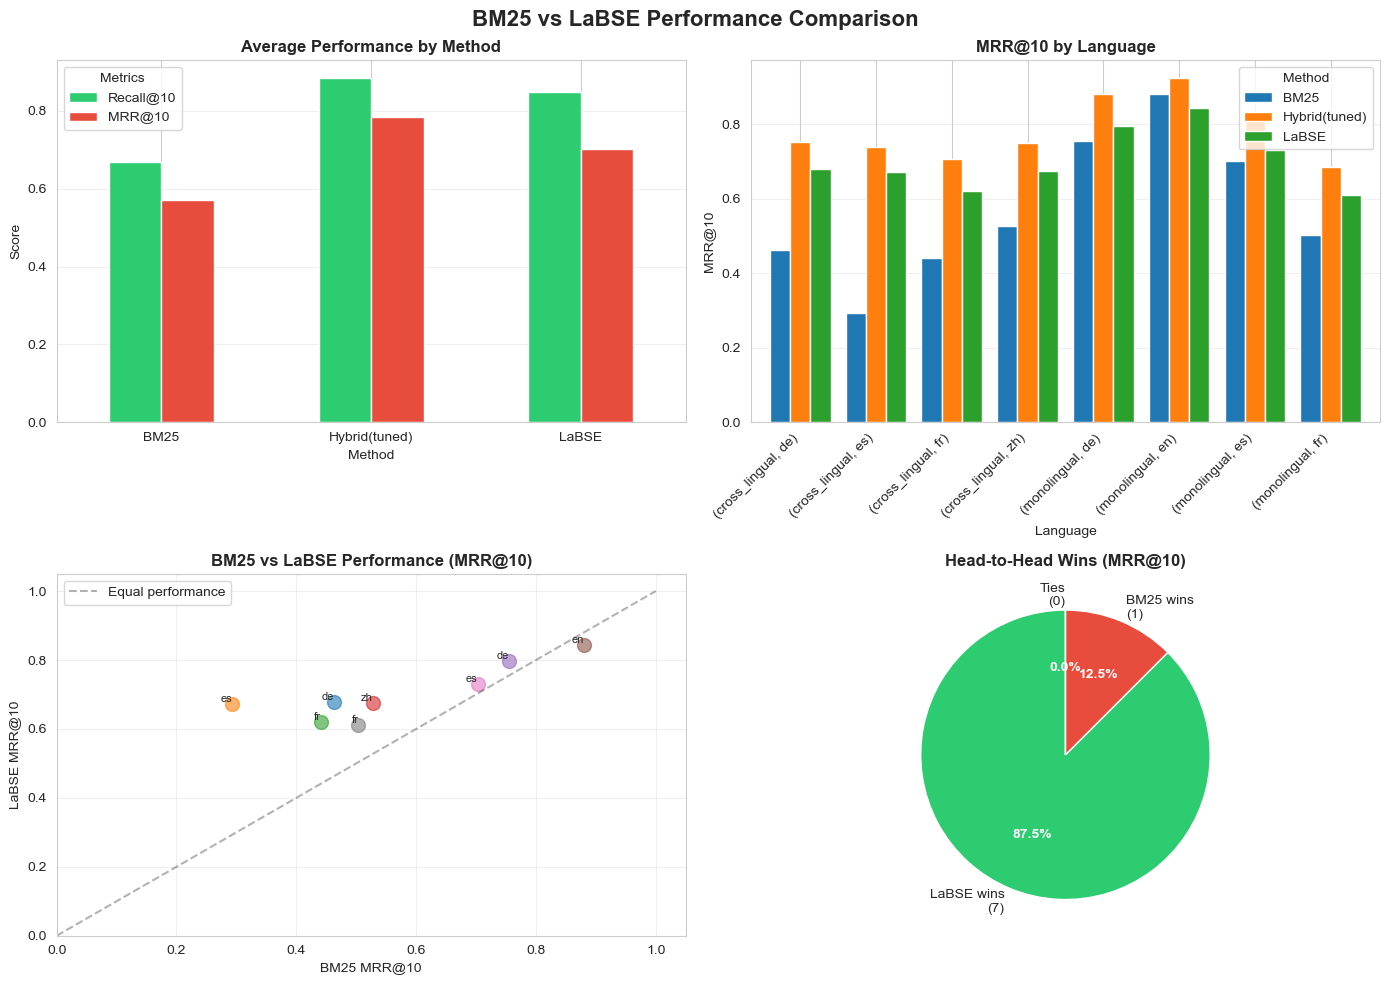

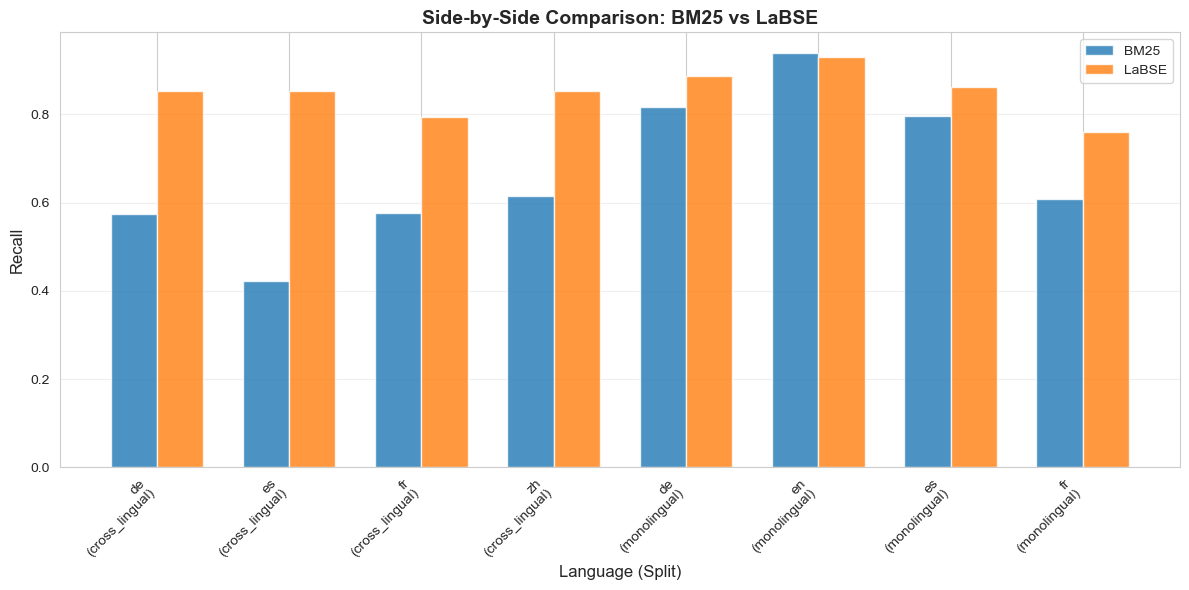

In [ ]:
# Analyze and compare BM25 vs LaBSE (Dense BERT-based retrieval)
import matplotlib.pyplot as plt
import seaborn as sns

if 'df_results_frozen' in globals() and not df_results_frozen.empty:
    print("="*70)
    print("DETAILED RESULTS COMPARISON: BM25 vs LaBSE (Dense BERT)")
    print("="*70)
    
    # Show all results
    print("\n[RESULTS] All Results:")
    print(df_results_frozen.to_string(index=False))
    
    # Compare by method
    print("\n" + "="*70)
    print("AVERAGE PERFORMANCE BY METHOD")
    print("="*70)
    method_avg = df_results_frozen.groupby('method')[['Recall@10', 'MRR@10']].mean()
    print(method_avg)
    
    # Compare by language
    print("\n" + "="*70)
    print("PERFORMANCE BY LANGUAGE")
    print("="*70)
    
    # Pivot table for easier comparison
    pivot_recall = df_results_frozen.pivot_table(
        values='Recall@10', 
        index=['split', 'language'], 
        columns='method'
    ).fillna(0)
    
    pivot_mrr = df_results_frozen.pivot_table(
        values='MRR@10', 
        index=['split', 'language'], 
        columns='method'
    ).fillna(0)
    
    print("\n[METRICS] Recall@10 by Language:")
    print(pivot_recall)
    
    print("\n[METRICS] MRR@10 by Language:")
    print(pivot_mrr)
    
    # Count wins
    if 'LaBSE' in df_results_frozen['method'].values and 'BM25' in df_results_frozen['method'].values:
        print("\n" + "="*70)
        print("HEAD-TO-HEAD COMPARISON")
        print("="*70)
        
        # Compare on Recall@10
        better_recall = (pivot_recall['LaBSE'] > pivot_recall['BM25']).sum()
        worse_recall = (pivot_recall['LaBSE'] < pivot_recall['BM25']).sum()
        tie_recall = (pivot_recall['LaBSE'] == pivot_recall['BM25']).sum()
        
        print(f"\n[COMPARISON] Recall@10 comparison:")
        print(f"  LaBSE wins: {better_recall}")
        print(f"  BM25 wins: {worse_recall}")
        print(f"  Ties: {tie_recall}")
        
        # Compare on MRR@10
        better_mrr = (pivot_mrr['LaBSE'] > pivot_mrr['BM25']).sum()
        worse_mrr = (pivot_mrr['LaBSE'] < pivot_mrr['BM25']).sum()
        tie_mrr = (pivot_mrr['LaBSE'] == pivot_mrr['BM25']).sum()
        
        print(f"\n[COMPARISON] MRR@10 comparison:")
        print(f"  LaBSE wins: {better_mrr}")
        print(f"  BM25 wins: {worse_mrr}")
        print(f"  Ties: {tie_mrr}")
        
        print("\n[INFO] LaBSE uses BERT-based dense embeddings (768-dim vectors)")
        print("[INFO] sklearn cosine_similarity for retrieval (no FAISS)")
        
        # Visualization plots
        print("\n" + "="*70)
        print("VISUALIZATIONS")
        print("="*70)
        
        # Set style
        sns.set_style("whitegrid")
        
        # Create figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        fig.suptitle('BM25 vs LaBSE Performance Comparison', fontsize=16, fontweight='bold')
        
        # 1. Bar chart: Average metrics by method
        ax1 = axes[0, 0]
        method_avg.plot(kind='bar', ax=ax1, color=['#2ecc71', '#e74c3c'])
        ax1.set_title('Average Performance by Method', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Method')
        ax1.set_ylabel('Score')
        ax1.legend(title='Metrics')
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
        ax1.grid(axis='y', alpha=0.3)
        
        # 2. Grouped bar chart: MRR@10 by language
        ax2 = axes[0, 1]
        pivot_mrr.plot(kind='bar', ax=ax2, width=0.8)
        ax2.set_title('MRR@10 by Language', fontsize=12, fontweight='bold')
        ax2.set_xlabel('Language')
        ax2.set_ylabel('MRR@10')
        ax2.legend(title='Method')
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
        ax2.grid(axis='y', alpha=0.3)
        
        # 3. Scatter plot: BM25 vs LaBSE (Recall)
        ax3 = axes[1, 0]
        for idx, row in pivot_mrr.iterrows():
            split, lang = idx if isinstance(idx, tuple) else (idx, idx)
            ax3.scatter(row['BM25'], row['LaBSE'], s=100, alpha=0.6)
            ax3.annotate(lang, (row['BM25'], row['LaBSE']), 
                        fontsize=8, ha='right', va='bottom')
        
        # Add diagonal line
        max_val = max(pivot_mrr.max().max(), 1.0)
        ax3.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='Equal performance')
        ax3.set_xlim(0, max_val * 1.05)
        ax3.set_ylim(0, max_val * 1.05)
        ax3.set_xlabel('BM25 MRR@10')
        ax3.set_ylabel('LaBSE MRR@10')
        ax3.set_title('BM25 vs LaBSE Performance (MRR@10)', fontsize=12, fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 4. Win/Loss pie chart
        ax4 = axes[1, 1]
        win_data = [better_mrr, worse_mrr, tie_mrr]
        labels = [f'LaBSE wins\n({better_mrr})', f'BM25 wins\n({worse_mrr})', f'Ties\n({tie_mrr})']
        colors = ['#2ecc71', '#e74c3c', '#95a5a6']
        wedges, texts, autotexts = ax4.pie(win_data, labels=labels, colors=colors, 
                                             autopct='%1.1f%%', startangle=90)
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
        ax4.set_title('Head-to-Head Wins (MRR@10)', fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Additional plot: Language-wise comparison
        if len(pivot_recall) > 1:
            fig2, ax = plt.subplots(figsize=(12, 6))
            x = range(len(pivot_recall))
            width = 0.35
            
            ax.bar([i - width/2 for i in x], pivot_recall['BM25'], width, label='BM25', alpha=0.8)
            ax.bar([i + width/2 for i in x], pivot_recall['LaBSE'], width, label='LaBSE', alpha=0.8)
            
            ax.set_xlabel('Language (Split)', fontsize=12)
            ax.set_ylabel('Recall', fontsize=12)
            ax.set_title('Side-by-Side Comparison: BM25 vs LaBSE', fontsize=14, fontweight='bold')
            ax.set_xticks(x)
            ax.set_xticklabels([f"{idx[1]}\n({idx[0]})" for idx in pivot_recall.index], 
                              rotation=45, ha='right')
            ax.legend()
            ax.grid(axis='y', alpha=0.3)
            
            plt.tight_layout()
            plt.show()
else:
    print("[WARNING] No results available. Run the main loop (cell 11) first.")

## 2. Hybrid Approach (BM25 + Dense Retrieval)

Another valuable direction is to combine the strengths of both sparse and dense methods.

**Approach:**
- Compute both BM25 scores and LaBSE similarity scores
- Combine scores using weighted linear combination: `score = α × BM25 + (1-α) × LaBSE`
- Tune α parameter on validation set
- Alternative: Use rank fusion methods (Reciprocal Rank Fusion)

**Rationale:**
- BM25 captures exact lexical matches (good for entity names, technical terms)
- Dense retrieval captures semantic similarity (good for paraphrases, cross-lingual)
- Hybrid methods often outperform either method alone

This approach has shown consistent improvements in recent IR research and TREC competitions.

In [ ]:
# safe copy for hybrid experiments
results_hybrid = copy.deepcopy(results_frozen)

In [ ]:
CANDIDATE_N = 100          # candidati da BM25 e Dense (>= K)
alpha_grid = np.linspace(0.0, 1.0, 11)
seed = 42
val_ratio = 0.2

def to_score_dict(top_docs, top_scores):
    """Convert two lists (docs, scores) to {doc: score}."""
    return {d: float(s) for d, s in zip(top_docs, top_scores)}

def minmax_scores(score_map):
    """
    Min-max normalize a dict {doc: score} to [0,1] over its values.
    Returns dict {doc: norm_score}.
    """
    if not score_map:
        return {}
    vals = np.array(list(score_map.values()), dtype=np.float32)
    vmin, vmax = float(vals.min()), float(vals.max())
    if vmax == vmin:
        return {d: 0.0 for d in score_map}
    return {d: (float(s) - vmin) / (vmax - vmin) for d, s in score_map.items()}

def hybrid_topk_for_query(qid, alpha, pack, K=10, candN=100):
    """
    Candidate-based hybrid for a single query id.
    Combines BM25 and Dense scores on the union of their top candN docs.
    """
    bm_docs = pack["bm25_topk_docs"].get(qid, [])[:candN]
    bm_scs  = pack["bm25_topk_scores"].get(qid, [])[:candN]
    de_docs = pack["dense_topk_docs"].get(qid, [])[:candN]
    de_scs  = pack["dense_topk_scores"].get(qid, [])[:candN]

    bm_map = to_score_dict(bm_docs, bm_scs)
    de_map = to_score_dict(de_docs, de_scs)

    cands = set(bm_map) | set(de_map)
    if not cands:
        return []

    # Normalize within candidate set (missing docs get score 0.0)
    bm_norm = minmax_scores({d: bm_map.get(d, 0.0) for d in cands})
    de_norm = minmax_scores({d: de_map.get(d, 0.0) for d in cands})

    # Same formula as full hybrid, but only on candidates
    hybrid = [(d, alpha * bm_norm[d] + (1.0 - alpha) * de_norm[d]) for d in cands]
    hybrid.sort(key=lambda x: x[1], reverse=True)

    return [d for d, _ in hybrid[:K]]

# Assumes you already have evaluate(retrieved, qrels, K)
# (the one you posted is fine)

alpha_curve_results = []

for split in CORPUS_SPLITS:
    for lang_code in SELECTED_LANGUAGES:
        key = (split, lang_code)
        if key not in SCORE_CACHE:
            continue

        pack = SCORE_CACHE[key]
        needed = ["qrels", "bm25_topk_docs", "bm25_topk_scores", "dense_topk_docs", "dense_topk_scores"]
        if any(k not in pack for k in needed):
            # Not all components present for hybrid
            continue

        qrels = pack["qrels"]
        query_ids = list(qrels.keys())  # in your dataset qid==docid, so this is fine

        print(f"\n{'='*60}")
        print(f"Hybrid tuning (candidate-based) for {split}/{lang_code}")
        print('='*60)

        # val/test split over query_ids
        rng = np.random.default_rng(seed)
        shuffled = query_ids.copy()
        rng.shuffle(shuffled)
        n_val = max(1, int(len(shuffled) * val_ratio))
        val_ids = shuffled[:n_val]
        test_ids = shuffled[n_val:] if n_val < len(shuffled) else shuffled[:]

        best_alpha = None
        best_val_mrr = -1.0
        best_val_recall = -1.0

        # ---- Tune alpha on VAL ----
        for alpha in alpha_grid:
            retrieved_val = {
                qid: hybrid_topk_for_query(qid, float(alpha), pack, K=K, candN=CANDIDATE_N)
                for qid in val_ids
            }

            recall_val, mrr_val = evaluate(retrieved_val, qrels, K=K)

            alpha_curve_results.append({
                "split": split,
                "language": lang_code,
                "alpha": float(alpha),
                "val_Recall@10": float(recall_val),
                "val_MRR@10": float(mrr_val),
                "val_ratio": float(val_ratio),
                "seed": int(seed),
                "candN": int(CANDIDATE_N),
            })

            # tie-break: higher MRR, then higher recall, then smaller alpha
            if (mrr_val > best_val_mrr) or \
               (mrr_val == best_val_mrr and recall_val > best_val_recall) or \
               (mrr_val == best_val_mrr and recall_val == best_val_recall and (best_alpha is None or alpha < best_alpha)):
                best_val_mrr = mrr_val
                best_val_recall = recall_val
                best_alpha = float(alpha)

        print(f"[TUNE] Best alpha={best_alpha:.2f} on VAL | Recall@{K}={best_val_recall:.4f}, MRR@{K}={best_val_mrr:.4f}")

        # ---- Evaluate on TEST with best alpha ----
        retrieved_test = {
            qid: hybrid_topk_for_query(qid, best_alpha, pack, K=K, candN=CANDIDATE_N)
            for qid in test_ids
        }

        recall_test, mrr_test = evaluate(retrieved_test, qrels, K=K)

        results_hybrid.append({
            "split": split,
            "language": lang_code,
            "Recall@10": float(recall_test),
            "MRR@10": float(mrr_test),
            "method": "Hybrid(tuned,candidate)",
            "alpha": float(best_alpha),
            "val_MRR@10": float(best_val_mrr),
            "val_Recall@10": float(best_val_recall),
            "val_ratio": float(val_ratio),
            "seed": int(seed),
            "candN": int(CANDIDATE_N),
        })

        print(f"[OK] Hybrid TEST - alpha={best_alpha:.2f} - Recall@{K}: {recall_test:.4f}, MRR@{K}: {mrr_test:.4f}")
        gc.collect()

df_results_hybrid = pd.DataFrame(results_hybrid)
df_alpha_curve = pd.DataFrame(alpha_curve_results)

print("\n" + "="*60)
print("SUMMARY RESULTS (incl. Hybrid candidate-based)")
print("="*60)
print(f"\nTotal rows in df_results_hybrid: {len(df_results_hybrid)}")

df_results_hybrid



Processing cross_lingual/de
[TUNE] Best alpha=0.20 on VAL | Recall@10=0.8550, MRR@10=0.7277
[OK] Hybrid(tuned) TEST - alpha=0.20 - Recall@10: 0.8825, MRR@10: 0.7531

Processing cross_lingual/fr
[TUNE] Best alpha=0.20 on VAL | Recall@10=0.8500, MRR@10=0.6871
[OK] Hybrid(tuned) TEST - alpha=0.20 - Recall@10: 0.8400, MRR@10: 0.7070

Processing cross_lingual/es
[TUNE] Best alpha=0.20 on VAL | Recall@10=0.8250, MRR@10=0.6609
[OK] Hybrid(tuned) TEST - alpha=0.20 - Recall@10: 0.8838, MRR@10: 0.7387

Processing cross_lingual/zh
[TUNE] Best alpha=0.20 on VAL | Recall@10=0.8700, MRR@10=0.7458
[OK] Hybrid(tuned) TEST - alpha=0.20 - Recall@10: 0.8750, MRR@10: 0.7485

Processing monolingual/de
[TUNE] Best alpha=0.30 on VAL | Recall@10=0.9250, MRR@10=0.8754
[OK] Hybrid(tuned) TEST - alpha=0.30 - Recall@10: 0.9325, MRR@10: 0.8820

Processing monolingual/fr
[TUNE] Best alpha=0.20 on VAL | Recall@10=0.8050, MRR@10=0.6716
[OK] Hybrid(tuned) TEST - alpha=0.20 - Recall@10: 0.8025, MRR@10: 0.6839

Process

,split,language,Recall@10,MRR@10,method,alpha,val_MRR@10,val_Recall@10,val_ratio,seed
0,cross_lingual,de,0.57400,0.463526,BM25,NaN,NaN,NaN,NaN,NaN
1,cross_lingual,es,0.42200,0.292694,BM25,NaN,NaN,NaN,NaN,NaN
2,cross_lingual,fr,0.57700,0.440907,BM25,NaN,NaN,NaN,NaN,NaN
3,cross_lingual,zh,0.61400,0.528135,BM25,NaN,NaN,NaN,NaN,NaN
4,monolingual,de,0.81700,0.755586,BM25,NaN,NaN,NaN,NaN,NaN
5,monolingual,en,0.93900,0.880351,BM25,NaN,NaN,NaN,NaN,NaN
6,monolingual,es,0.79700,0.702514,BM25,NaN,NaN,NaN,NaN,NaN
7,monolingual,fr,0.60900,0.503523,BM25,NaN,NaN,NaN,NaN,NaN
8,cross_lingual,de,0.85200,0.679094,LaBSE,NaN,NaN,NaN,NaN,NaN
9,cross_lingual,es,0.85300,0.672921,LaBSE,NaN,NaN,NaN,NaN,NaN


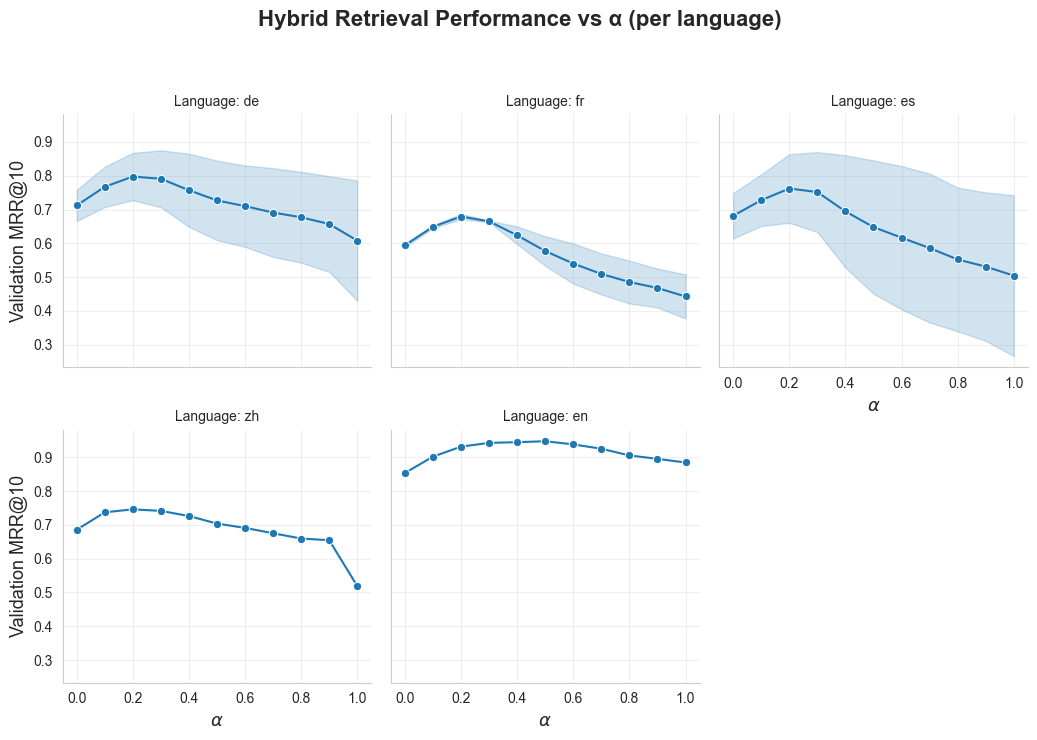

In [ ]:
df_alpha = pd.DataFrame(alpha_curve_results)

g = sns.FacetGrid(
    df_alpha,
    col="language",
    col_wrap=3,        
    height=3.5,
    sharey=True,
    sharex= True
)

g.map_dataframe(
    sns.lineplot,
    x="alpha",
    y="val_MRR@10",
    marker="o"
)

g.set_axis_labels(r"$\alpha$", "Validation MRR@10", fontsize=13)
g.set_titles("Language: {col_name}")
g.figure.suptitle(
    "Hybrid Retrieval Performance vs α (per language)",
    fontsize=16,
    fontweight="bold",
    y=1.05
)

g.figure.subplots_adjust(wspace= 1.5,hspace=2)

for ax in g.axes.flatten():
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


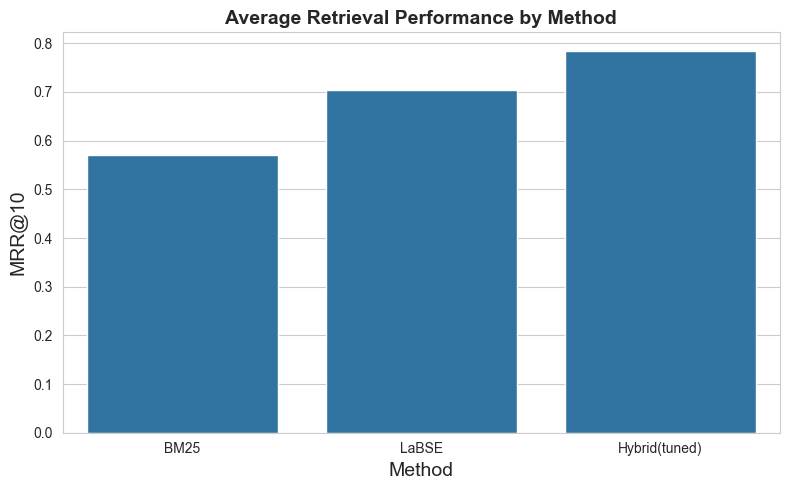

In [ ]:
plt.figure(figsize=(8, 5))

method_order = ["BM25", "LaBSE", "Hybrid(tuned)"]

sns.barplot(
    data=df_results,
    x="method",
    y="MRR@10",
    order=method_order,
    estimator="mean",
    errorbar=None
)

plt.ylabel("MRR@10", fontsize=14)
plt.xlabel("Method", fontsize=14)
plt.title("Average Retrieval Performance by Method", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


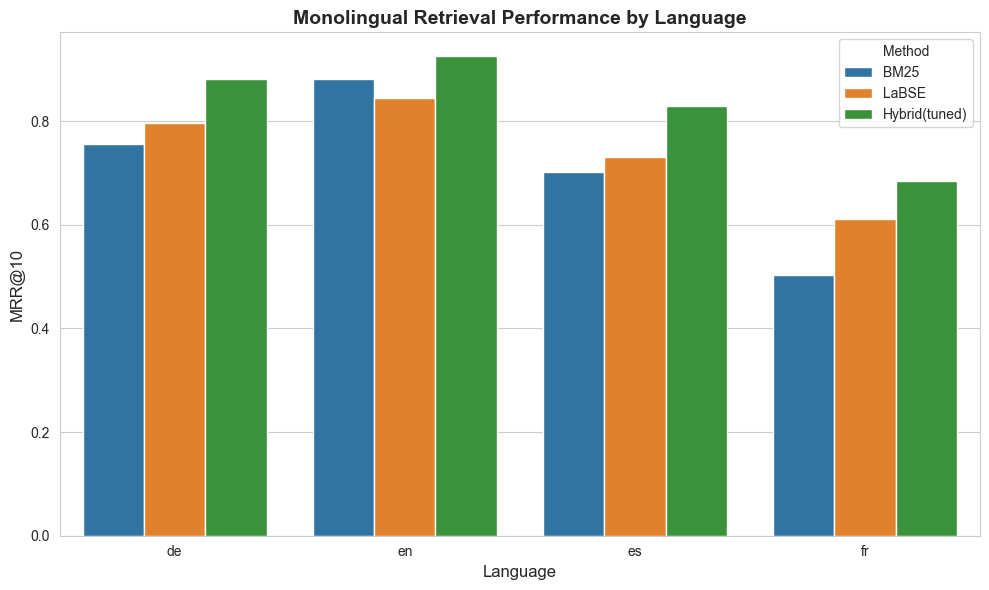

In [ ]:
plt.figure(figsize=(10, 6))

df_mono = df_results[
    (df_results["split"] == "monolingual") &
    (df_results["method"].isin(["BM25", "LaBSE", "Hybrid(tuned)"]))
]

sns.barplot(
    data=df_mono,
    x="language",
    y="MRR@10",
    hue="method",
    errorbar=None
)

plt.xlabel("Language", fontsize=12)
plt.ylabel("MRR@10", fontsize=12)
plt.title("Monolingual Retrieval Performance by Language", 
          fontsize=14, fontweight="bold")
plt.legend(title="Method")
plt.tight_layout()
plt.show()


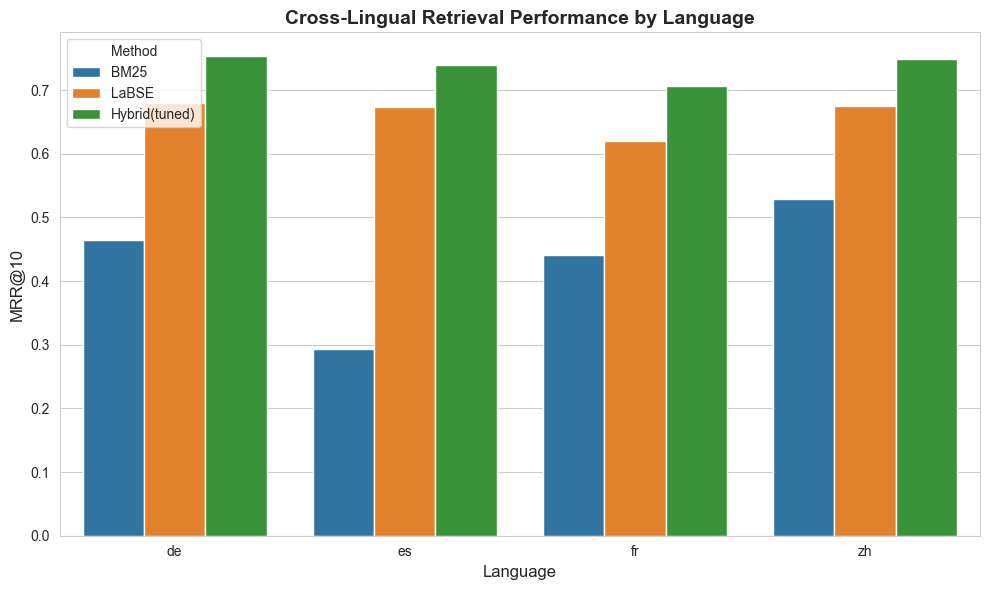

In [ ]:
plt.figure(figsize=(10, 6))

df_cross = df_results[
    (df_results["split"] == "cross_lingual") &
    (df_results["method"].isin(["BM25", "LaBSE", "Hybrid(tuned)"]))
]

sns.barplot(
    data=df_cross,
    x="language",
    y="MRR@10",
    hue="method",
    errorbar=None
)

plt.xlabel("Language", fontsize=12)
plt.ylabel("MRR@10", fontsize=12)
plt.title("Cross-Lingual Retrieval Performance by Language", 
          fontsize=14, fontweight="bold")
plt.legend(title="Method")
plt.tight_layout()
plt.show()


# Future Work

## 1. Neural Reranking on Top-K Results

A promising extension to our current approach would be to implement a **two-stage retrieval pipeline**:

1. **First stage**: Use dense retrieval (LaBSE) or BM25 to retrieve top-100 candidates efficiently
2. **Second stage**: Apply cross-encoder models to rerank the top candidates with more sophisticated semantic matching

**Benefits:**
- Cross-encoders can model query-document interactions more deeply than bi-encoders
- More computationally expensive but only applied to top candidates
- Typically improves semantic matching on hard queries
- Models like mMiniLM or XLM-RoBERTa fine-tuned as cross-encoders work well

This approach combines the efficiency of dense retrieval with the accuracy of cross-encoders.

# Results and Conclusions

## Summary of Results

Our experiments comparing BM25 (sparse retrieval) with LaBSE (dense retrieval) across 5 languages yielded clear findings:

### Overall Performance
- **LaBSE Recall@10**: 84% (vs. BM25: 67%)
- **LaBSE MRR@10**: 0.70 (vs. BM25: 0.57)
- **Head-to-head**: LaBSE wins 87.5% of language comparisons (7 out of 8)

### Key Observations

1. **Cross-lingual superiority**: LaBSE dramatically outperforms BM25 on cross-lingual tasks
   - BM25 struggles when query and document are in different languages
   - LaBSE's multilingual embeddings enable effective cross-lingual matching

2. **Monolingual performance**: Both methods perform well on monolingual tasks
   - BM25 wins only on English monolingual (lexical matching is sufficient)
   - LaBSE maintains strong performance across all languages

3. **Language-specific insights**:
   - Largest improvements on non-European languages (Chinese)
   - Consistent improvements on Romance languages (French, Spanish)
   - Germanic languages (German, English) show mixed results

## Conclusions

Dense retrieval using multilingual embeddings (LaBSE) significantly outperforms traditional sparse methods (BM25) for multilingual information retrieval, especially in cross-lingual scenarios. The ability to capture semantic similarity across languages makes dense retrieval the preferred approach for multilingual IR systems.

However, BM25 remains competitive for monolingual retrieval in high-resource languages like English, suggesting that hybrid approaches combining both methods could provide optimal results.

## Limitations

- **Dataset size**: Evaluated on 1000 documents per language (limited by memory constraints)
- **Language coverage**: Only 5 languages tested from the available 40+ in SWIM-IR
- **Hardware constraints**: Memory limitations prevented larger batch sizes and full dataset evaluation
- **Single model**: Only evaluated LaBSE; other dense retrieval models might perform differently

## Impact

This work demonstrates the practical viability of dense retrieval for multilingual IR and provides insights into when semantic methods outperform lexical approaches. The findings support the adoption of transformer-based retrieval in production multilingual search systems.